In [ ]:
!pip install tensorflow==2.16.0rc0
!PYTHONHASHSEED=0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 48.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
# Import other modules
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import pandas as pd
import random as python_random
import os
import shutil
import glob

# Import TensorFlow/Keras
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, MaxPooling3D, concatenate, Dropout, Activation, BatchNormalization, GroupNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K


from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Zip file's path on grive
drive_zip_path = '/content/gdrive/MyDrive/DL_Project/data/128.zip'
local_extract_path = '/content/Training_Data'
os.makedirs(local_extract_path, exist_ok=True
            )
# Unzip file on local directory
with zipfile.ZipFile(drive_zip_path, 'r') as zip_ref:
    zip_ref.extractall(local_extract_path)

print("Decompressione completata.")

Decompressione completata.


### DATA GENERATOR --> batch size = 256

In [ ]:
import numpy as np  # Import the numpy library for array manipulation

# Function to load images from a given directory and list of image file names
def load_img(img_dir, img_list):
    images = []  # Initialize an empty list to store the images
    for image_name in img_list:  # Loop through each image name in the list
        if image_name.split('.')[-1] == 'npy':  # Check if the file is a .npy file
            volume = np.load(img_dir + image_name)  # Load the .npy file as a numpy array
            # Extract 128 images along the third axis (z-axis) from each volume
            for j in range(volume.shape[2]):
                images.append(volume[:, :, j, :])  # Append each slice to the images list
    images = np.array(images)  # Convert the list of images to a numpy array
    return images  # Return the numpy array of images

# Generator function to load and yield image and mask batches
def image_loader(img_dir, img_list, mask_dir, mask_list, batch_size=256):
    assert batch_size == 256, "Batch size must be 256 to match the number of slices per two volumes."  # Ensure batch size is 256

    L = len(img_list)  # Get the length of the image list

    while True:  # Infinite loop to keep yielding batches
        for i in range(0, L, 2):  # Iterate through the image list in steps of 2
            if i + 1 < L:  # Check if there are at least two more volumes to load
                img = load_img(img_dir, [img_list[i], img_list[i+1]])  # Load images from two volumes
                mask = load_img(mask_dir, [mask_list[i], mask_list[i+1]])  # Load corresponding masks

                # Combine images and masks into a list of tuples and shuffle them
                combined = list(zip(img, mask))
                np.random.shuffle(combined)
                img[:], mask[:] = zip(*combined)  # Unzip the shuffled list back into images and masks

                yield (img, mask)  # Yield the shuffled images and masks as a batch
            else:
                # Handle the case where there is an odd number of volumes
                img = load_img(img_dir, [img_list[i]])  # Load images from the last volume
                mask = load_img(mask_dir, [mask_list[i]])  # Load corresponding masks

                # Combine images and masks into a list of tuples and shuffle them
                combined = list(zip(img, mask))
                np.random.shuffle(combined)
                img[:], mask[:] = zip(*combined)  # Unzip the shuffled list back into images and masks

                yield (img, mask)  # Yield the shuffled images and masks as a batch

### ENVIROMMENT

In [ ]:
train_img_dir = '/content/Training_Data/X_train'
train_mask_dir = '/content/Training_Data/Y_train'

val_img_dir = '/content/Training_Data/X_val'
val_mask_dir = '/content/Training_Data/Y_val'

In [ ]:
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

### DEFINE PARAMETERS AND FUNCTIONS OF THE MODEL

In [ ]:
steps_per_epoch = len(train_img_list)//2
val_steps_per_epoch = len(val_img_list)//2

In [ ]:
#Define the optimizer
batch_size = 256

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 5e-4,
    decay_steps  = (steps_per_epoch),
    decay_rate = 0.985)

optim = keras.optimizers.Adam(learning_rate = lr_schedule)

In [ ]:
#Compute weight of classes

columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/Training_Data/Y_train/*.npy'))
for img in range(len(train_mask_list)):

  temp_image=np.load(train_mask_list[img])
  temp_image = np.argmax(temp_image, axis=3)
  val, counts = np.unique(temp_image, return_counts=True)

  conts_dict = {str(i): 0 for i in range(4)}
  for v, c in zip(val, counts):
    conts_dict[str(v)] = c

  row_df = pd.DataFrame([conts_dict])

  df = pd.concat([df, row_df], ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

print(wt0, wt1, wt2, wt3)

0.26 8.56 29.69 27.28


In [ ]:
CFC_loss = keras.losses.CategoricalFocalCrossentropy(alpha = [wt0, wt1, wt2, wt3])

In [ ]:
IoU_0 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [0])
IoU_1 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [1])
IoU_2 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [2])
IoU_3 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [3])

Mean_IoU = keras.metrics.OneHotMeanIoU(num_classes = 4)

metrics = ["accuracy",  Mean_IoU, IoU_0, IoU_1, IoU_2, IoU_3]

### MODEL ARCHITECTURE

In [ ]:
l2 = tf.keras.regularizers.L2(
    l2 = 0.0001
)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Activation, concatenate, SpatialDropout2D
from tensorflow.keras.models import Model

def conv_block_2d(input, n_filters):
    x = Conv2D(n_filters, 3, padding='same', kernel_regularizer = l2)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_filters, 3, padding='same', kernel_regularizer = l2)(x)
    x = SpatialDropout2D(rate = 0.2, data_format = "channels_last") (x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block_2d(input, num_filters):
    x = conv_block_2d(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block_2d(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    x = concatenate([x, skip_features])
    x = conv_block_2d(x, num_filters)
    return x


In [ ]:

def create_augmentation_block():
  augmentation_layers = tf.keras.Sequential([
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomZoom(0.2)
    ])
  return augmentation_layers


In [ ]:
def build_unet_2d(input_shape, n_classes):

    inputs = Input(input_shape)

    augmentation_block = create_augmentation_block()
    augmented_inputs = augmentation_block(inputs, training=True)

    s1, p1 = encoder_block_2d(augmented_inputs, 32)
    s2, p2 = encoder_block_2d(p1, 64)
    s3, p3 = encoder_block_2d(p2, 128)
    s4, p4 = encoder_block_2d(p3, 256)

    b1 = conv_block_2d(p4, 512)

    d1 = decoder_block_2d(b1, s4, 256)
    d2 = decoder_block_2d(d1, s3, 128)
    d3 = decoder_block_2d(d2, s2, 64)
    d4 = decoder_block_2d(d3, s1, 32)

    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(d4)

    model = Model(inputs, outputs, name='2D_U-Net')
    return model

input_shape = (128, 128, 4)
n_classes = 4

model0 = build_unet_2d(input_shape, n_classes)
model0.compile(optimizer = optim, loss = CFC_loss, metrics = metrics)
model0.summary()

Model: "2D_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 128, 128, 4)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 128, 128, 32)   │          1,184 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 128, 128, 32)   │            128 │ conv2d_76[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_72             │ (None, 128, 128, 32)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ activation_72[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_36      │ (None, 128, 128, 32)   │              0 │ conv2d_77[0][0]        │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 128, 128, 32)   │            128 │ spatial_dropout2d_36[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_73             │ (None, 128, 128, 32)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 64, 64, 32)     │              0 │ activation_73[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 64, 64, 64)     │            256 │ conv2d_78[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_74             │ (None, 64, 64, 64)     │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ activation_74[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_37      │ (None, 64, 64, 64)     │              0 │ conv2d_79[0][0]        │
│ (SpatialDropout2D)   

 Total params: 7,772,260 (29.65 MB)

 Trainable params: 7,766,372 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
train_img_dir = '/content/Training_Data/X_train/'
train_mask_dir = '/content/Training_Data/Y_train/'

val_img_dir = '/content/Training_Data/X_val/'
val_mask_dir = '/content/Training_Data/Y_val/'

In [ ]:
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

train_img_list.sort()
train_mask_list.sort()

val_img_list.sort()
val_mask_list.sort()

In [ ]:
batch_size = 256

train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list)
val_img_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list)

steps_per_epoch = len(train_img_list)//2
val_steps_per_epoch = len(val_img_list)//2

In [ ]:
# Callback to save best model based on validation loss
checkpoint_path = "/content/gdrive/MyDrive/DL_Project/2D_Unet_DataAugm.h5.keras"

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only=True,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1
)

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',    # Track validation loss
    patience = 20,           # max number of epochs without improvments
    restore_best_weights = True,
    verbose = 1
  )

csv = keras.callbacks.CSVLogger("/content/gdrive/MyDrive/DL_Project/history_2d_DataAUgm.csv", separator=",", append=False)

In [ ]:
history = model0.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 100,
                    verbose = 1,
                    validation_data = val_img_datagen,
                    validation_steps = val_steps_per_epoch,
                    callbacks = [early_stopping_callback, csv]
)

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 110s 566ms/step - accuracy: 0.3296 - loss: 1.0230 - one_hot_io_u: 0.3903 - one_hot_io_u_1: 0.0487 - one_hot_io_u_2: 0.0163 - one_hot_io_u_3: 0.0171 - one_hot_mean_io_u: 0.1181 - val_accuracy: 0.4455 - val_loss: 0.8420 - val_one_hot_io_u: 0.4323 - val_one_hot_io_u_1: 0.0821 - val_one_hot_io_u_2: 0.0000e+00 - val_one_hot_io_u_3: 0.0200 - val_one_hot_mean_io_u: 0.1336
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 92s 545ms/step - accuracy: 0.4186 - loss: 0.7796 - one_hot_io_u: 0.4156 - one_hot_io_u_1: 0.0527 - one_hot_io_u_2: 0.0224 - one_hot_io_u_3: 0.0194 - one_hot_mean_io_u: 0.1275 - val_accuracy: 0.5527 - val_loss: 0.8516 - val_one_hot_io_u: 0.5504 - val_one_hot_io_u_1: 0.2057 - val_one_hot_io_u_2: 0.1166 - val_one_hot_io_u_3: 0.0148 - val_one_hot_mean_io_u: 0.2219
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 92s 545ms/step - accuracy: 0.4597 - loss: 0.7441 - one_hot_io_u: 0.4584 - one_hot_io_u_1: 0.0552 - one_hot_io_u_2: 0.0267 - one_hot_io_u_3: 0.0197

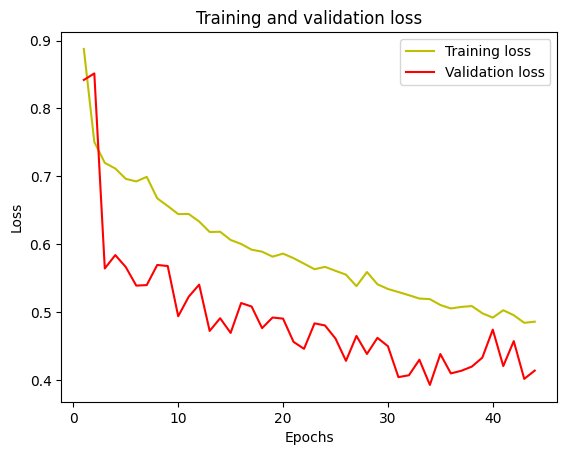

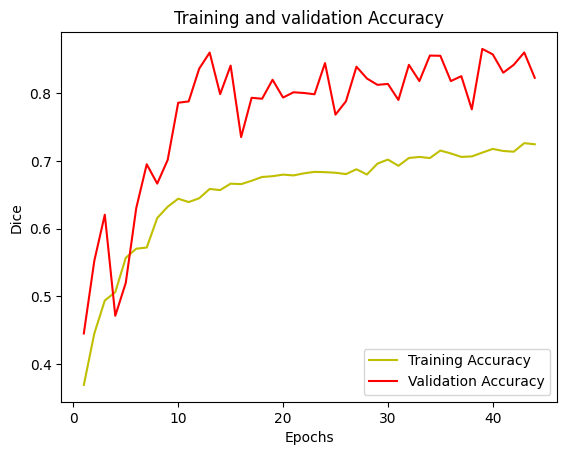

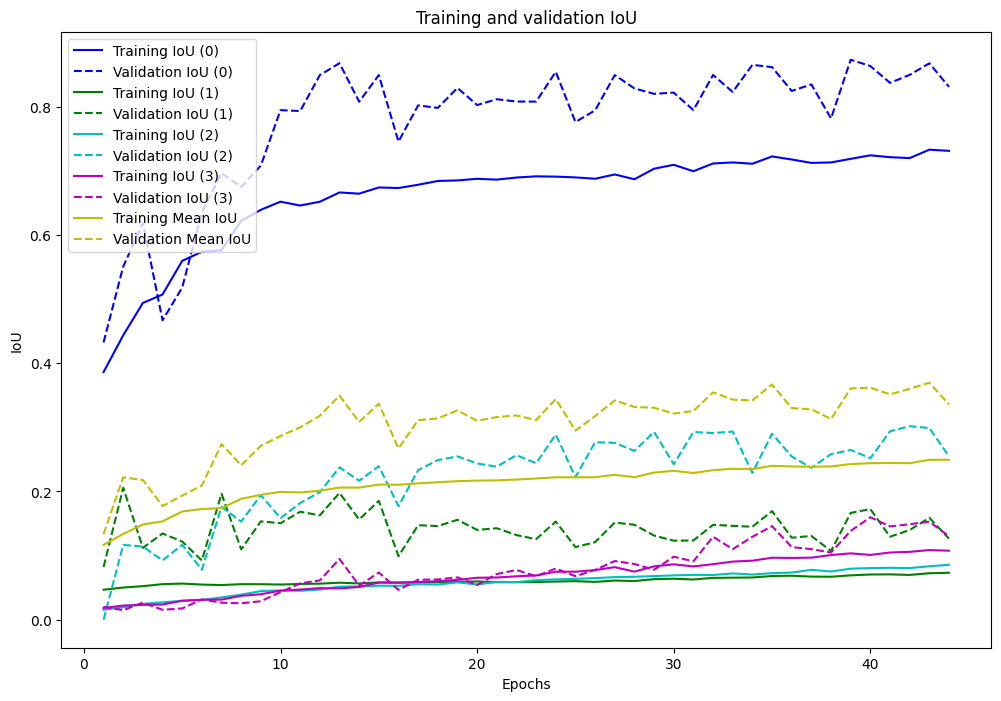

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()



a1 = history.history['one_hot_io_u']
a2 = history.history['val_one_hot_io_u']
b1 = history.history['one_hot_io_u_1']
b2 = history.history['val_one_hot_io_u_1']
c1 = history.history['one_hot_io_u_2']
c2 = history.history['val_one_hot_io_u_2']
d1 = history.history['one_hot_io_u_3']
d2 = history.history['val_one_hot_io_u_3']
e1 = history.history['one_hot_mean_io_u']
e2 = history.history['val_one_hot_mean_io_u']

colors = ['b', 'g', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 8))

plt.plot(epochs, a1, color=colors[0], linestyle=line_styles[0], label='Training IoU (0)')
plt.plot(epochs, a2, color=colors[0], linestyle=line_styles[1], label='Validation IoU (0)')
plt.plot(epochs, b1, color=colors[1], linestyle=line_styles[0], label='Training IoU (1)')
plt.plot(epochs, b2, color=colors[1], linestyle=line_styles[1], label='Validation IoU (1)')
plt.plot(epochs, c1, color=colors[2], linestyle=line_styles[0], label='Training IoU (2)')
plt.plot(epochs, c2, color=colors[2], linestyle=line_styles[1], label='Validation IoU (2)')
plt.plot(epochs, d1, color=colors[3], linestyle=line_styles[0], label='Training IoU (3)')
plt.plot(epochs, d2, color=colors[3], linestyle=line_styles[1], label='Validation IoU (3)')
plt.plot(epochs, e1, color=colors[4], linestyle=line_styles[0], label='Training Mean IoU')
plt.plot(epochs, e2, color=colors[4], linestyle=line_styles[1], label='Validation Mean IoU')

plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# TRY 64 FILTERS

In [ ]:
#Define the optimizer
batch_size = 256

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 5e-4,
    decay_steps  = (steps_per_epoch),
    decay_rate = 0.985)

optim = keras.optimizers.Adam(learning_rate = lr_schedule)

CFC_loss = keras.losses.CategoricalFocalCrossentropy(alpha = [wt0, wt1, wt2, wt3])

In [ ]:
def build_unet_2d(input_shape, n_classes):

    inputs = Input(input_shape)

    augmentation_block = create_augmentation_block()
    augmented_inputs = augmentation_block(inputs, training=True)

    s1, p1 = encoder_block_2d(augmented_inputs, 64)
    s2, p2 = encoder_block_2d(p1, 128)
    s3, p3 = encoder_block_2d(p2, 256)
    s4, p4 = encoder_block_2d(p3, 512)

    b1 = conv_block_2d(p4, 1024)

    d1 = decoder_block_2d(b1, s4, 512)
    d2 = decoder_block_2d(d1, s3, 256)
    d3 = decoder_block_2d(d2, s2, 128)
    d4 = decoder_block_2d(d3, s1,64 )

    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(d4)

    model = Model(inputs, outputs, name='2D_U-Net')
    return model

input_shape = (128, 128, 4)
n_classes = 4

model1 = build_unet_2d(input_shape, n_classes)
model1.compile(optimizer = optim, loss = CFC_loss, metrics = metrics)
model1.summary()

Model: "2D_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 128, 128, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 128, 128, 4)    │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 128, 128, 64)   │          2,368 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_90    │ (None, 128, 128, 64)   │            256 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_90             │ (None, 128, 128, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ activation_90[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_45      │ (None, 128, 128, 64)   │              0 │ conv2d_96[0][0]        │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_91    │ (None, 128, 128, 64)   │            256 │ spatial_dropout2d_45[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_91             │ (None, 128, 128, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 64, 64, 64)     │              0 │ activation_91[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_92    │ (None, 64, 64, 128)    │            512 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_92             │ (None, 64, 64, 128)    │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ activation_92[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_46      │ (None, 64, 64, 128)    │              0 │ conv2d_98[0][0]        │
│ (SpatialDropout2D)   

 Total params: 31,056,068 (118.47 MB)

 Trainable params: 31,044,292 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
train_img_dir = "/content/Training_Data/X_train/"
train_mask_dir = "/content/Training_Data/Y_train/"
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_dir = "/content/Training_Data/X_val/"
val_mask_dir = "/content/Training_Data/Y_val/"
val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))


batch_size = 256

train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

steps_per_epoch = len(train_img_list) // 2
val_steps_per_epoch = len(val_img_list) // 2

In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/DL_Project/2D_UNet_64_DataAugm.h5.keras"

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1
)

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 20,
    restore_best_weights = True
)
csv = keras.callbacks.CSVLogger("/content/gdrive/MyDrive/DL_Project/history64DataAugm.csv", separator=",", append=False)

In [ ]:
history = model1.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 100,
                    verbose = 1,
                    validation_data = val_img_datagen,
                    validation_steps = val_steps_per_epoch,
                    callbacks = [checkpoint_callback, early_stopping_callback, csv]
)

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.4166 - loss: 1.1580 - one_hot_io_u: 0.5486 - one_hot_io_u_1: 0.0593 - one_hot_io_u_2: 0.0308 - one_hot_io_u_3: 0.0331 - one_hot_mean_io_u: 0.1679
Epoch 1: val_loss improved from inf to 0.89444, saving model to /content/gdrive/MyDrive/DL_Project/2D_UNet_64_DataAugm.h5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 384s 903ms/step - accuracy: 0.4168 - loss: 1.1570 - one_hot_io_u: 0.5484 - one_hot_io_u_1: 0.0593 - one_hot_io_u_2: 0.0308 - one_hot_io_u_3: 0.0330 - one_hot_mean_io_u: 0.1679 - val_accuracy: 0.5174 - val_loss: 0.8944 - val_one_hot_io_u: 0.5108 - val_one_hot_io_u_1: 0.1251 - val_one_hot_io_u_2: 0.0022 - val_one_hot_io_u_3: 0.0120 - val_one_hot_mean_io_u: 0.1626
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.4220 - loss: 0.8334 - one_hot_io_u: 0.4217 - one_hot_io_u_1: 0.0523 - one_hot_io_u_2: 0.0215 - one_hot_io_u_3: 0.0183 - one_hot_mean_io_u: 0.1285
Epoch 2: val_loss improved from 0.89444 to 0.7437

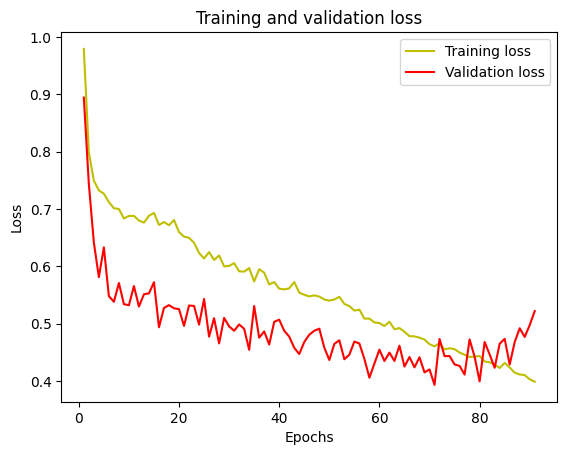

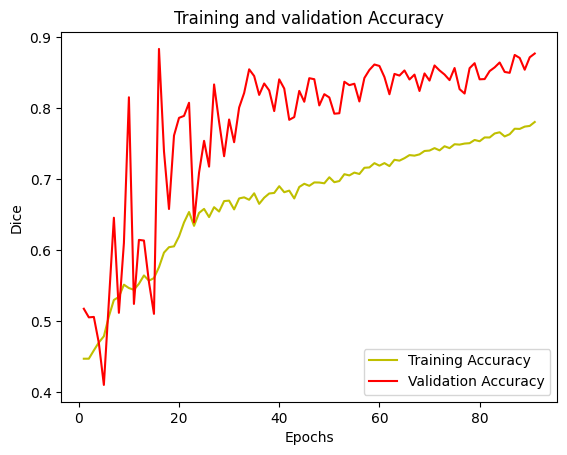

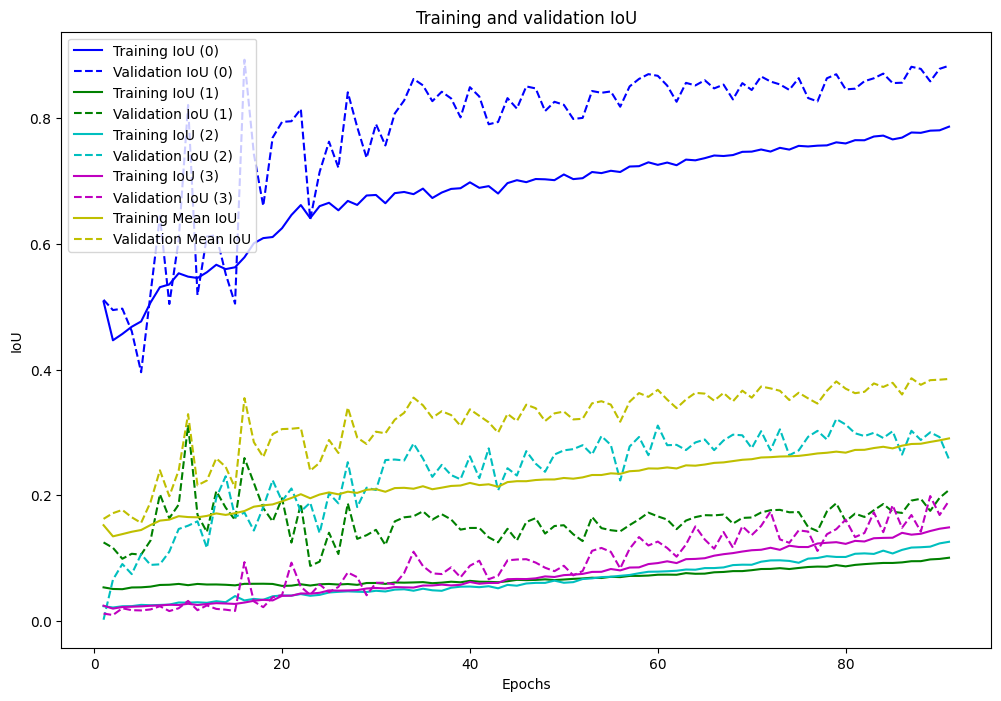

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()



a1 = history.history['one_hot_io_u']
a2 = history.history['val_one_hot_io_u']
b1 = history.history['one_hot_io_u_1']
b2 = history.history['val_one_hot_io_u_1']
c1 = history.history['one_hot_io_u_2']
c2 = history.history['val_one_hot_io_u_2']
d1 = history.history['one_hot_io_u_3']
d2 = history.history['val_one_hot_io_u_3']
e1 = history.history['one_hot_mean_io_u']
e2 = history.history['val_one_hot_mean_io_u']

colors = ['b', 'g', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 8))

plt.plot(epochs, a1, color=colors[0], linestyle=line_styles[0], label='Training IoU (0)')
plt.plot(epochs, a2, color=colors[0], linestyle=line_styles[1], label='Validation IoU (0)')
plt.plot(epochs, b1, color=colors[1], linestyle=line_styles[0], label='Training IoU (1)')
plt.plot(epochs, b2, color=colors[1], linestyle=line_styles[1], label='Validation IoU (1)')
plt.plot(epochs, c1, color=colors[2], linestyle=line_styles[0], label='Training IoU (2)')
plt.plot(epochs, c2, color=colors[2], linestyle=line_styles[1], label='Validation IoU (2)')
plt.plot(epochs, d1, color=colors[3], linestyle=line_styles[0], label='Training IoU (3)')
plt.plot(epochs, d2, color=colors[3], linestyle=line_styles[1], label='Validation IoU (3)')
plt.plot(epochs, e1, color=colors[4], linestyle=line_styles[0], label='Training Mean IoU')
plt.plot(epochs, e2, color=colors[4], linestyle=line_styles[1], label='Validation Mean IoU')

plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()